# Simple Decline Curve Analysis in Python

Created by Lukas Mosser, 2016

## Introduction
We will look at how we can use python and related libraries to perform a decline curve analysis on
a number of example datasets. 

The methodology shown here can be readily extended to additional decline curve types.

First off we will import a number of libraries that allow us to perform the curve fitting as well as plotting the data.

Especially the **scipy.optimize** library will allow us to perform curve fitting using a non-linear least squares method.

## Definitions

Decline curves provide us with an empirical method to predict expected ultimate recovery and cummulative production of a reservoir. We will not cover the theory of decline curve analysis as this is provided by a number of references in oil and gas literature (see references section).

We will distinguish the three classic types of decline curves: 

- Exponential decline
- Hyperbolic decline
- Harmonic decline

The production rate as a function of time is given as follows:

#### Exponential Decline
$$q(t)=q_i e^{-a\Delta t}$$
where $q_i$ is the initial rate, and $a$ is the decline rate. The exponential decline curve has one fitting parameter: $a$
#### Hyperbolic Decline
$$q(t)=\frac{q_i}{(1+ba_i\Delta t)^{(\frac{1}{b})}}$$
where $q_i$ is the initial rate, and $a_i$ is the decline rate, $b$ fractional exponent. The hyperbolic decline curve has two fitting parameters: $a_i$ and $b$
#### Harmonic Decline
$$q(t)=\frac{q_i}{(1+a_i\Delta t)}$$
where $q_i$ is the initial rate, and $a_i$ is the decline rate. The harmonic decline curve has one fitting parameter: $a_i$

## Turning theory into code

We will now turn our above decline curves into simple python methods. (Also known as functions)
To start off we will import a number of helper libraries to get us started and to provide
the necessary tools for curve fitting.

The **scipy** library and its module **scipy.optimize** allow us to use **curve_fit** to find the fitting parameters required for curve fitting.

In [1]:
from scipy.optimize import curve_fit

We will use **matplotlib** to perform any plotting tasks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The curve_fit method takes in three parameters at least. 
```
   popt, pcov = curve_fit(func, T, Q)
```
The first parameter is a function, we can pass them as we would pass any variable. This function needs to take in the independent parameter, in our case the time, as well as any fitting parameters. The second parameter is the independent variable in our case the elapsed time. The third parameter is the observed data that we want to fit.

We know the initial rate, and therefore we would like to pass this to our decline curve method. There is no functionality to pass the additional variable via **curve_fit**. But python allows us to define functions inside functions and therefore we have a simple workaround.

We define a function inside an if clause and set up our initial rate. The function **decline_curve** then returns our decline curve function which is then passed to **curve_fit**

Finally, we also define a simple L2 norm to estimate how good we've fit our data.

$$Error_{L2}=\sum{|{q(t)-q_{obs}(t)}|^2}$$

In [3]:
def decline_curve(curve_type, q_i):
    if curve_type == "exponential":
        def exponential_decline(T, a):
            return q_i*np.exp(-a*T)
        return exponential_decline
    
    elif curve_type == "hyperbolic":
        def hyperbolic_decline(T, a_i, b):
            return q_i/np.power((1+b*a_i*T), 1./b)
        return hyperbolic_decline
    
    elif curve_type == "harmonic":
        def parabolic_decline(T, a_i):
            return q_i/(1+a_i*T)
        return parabolic_decline
    
    else:
        raise "I don't know this decline curve!"

def L2_norm(Q, Q_obs):
    return np.sum(np.power(np.subtract(Q, Q_obs), 2))

## Loading the data

To load our data we will load from a csv file and skip the first line, our header using the keyword **skiprows**.
We then split our data into time and rate data independently.

In [4]:
data = np.loadtxt("data/prod_data_1.txt", skiprows=1, delimiter=",")
T, Q = data.T

Let's define our decline curves using our initial rate. We then pass these on to scipy.optimize.curve_fit and compute the L2 norm of the resulting fit.

In [5]:
exp_decline = decline_curve("exponential", Q[0])
hyp_decline = decline_curve("hyperbolic", Q[0])
har_decline = decline_curve("harmonic", Q[0])

popt_exp, pcov_exp = curve_fit(exp_decline, T, Q, method="trf")
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T, Q, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T, Q, method="trf")

print "L2 Norm of exponential decline: ", L2_norm(exp_decline(T, popt_exp[0]), Q)
print "L2 Norm of hyperbolic decline decline: ", L2_norm(hyp_decline(T, popt_hyp[0], popt_hyp[1]), Q)
print "L2 Norm of harmonic decline decline: ", L2_norm(har_decline(T, popt_har[0]), Q)

L2 Norm of exponential decline:  1.15449992701
L2 Norm of hyperbolic decline decline:  0.000223233409377
L2 Norm of harmonic decline decline:  0.496668402014


As we can see the hyperbolic decline fits the data much better than the other decline curves. We will now visualise the results using matplotlib.

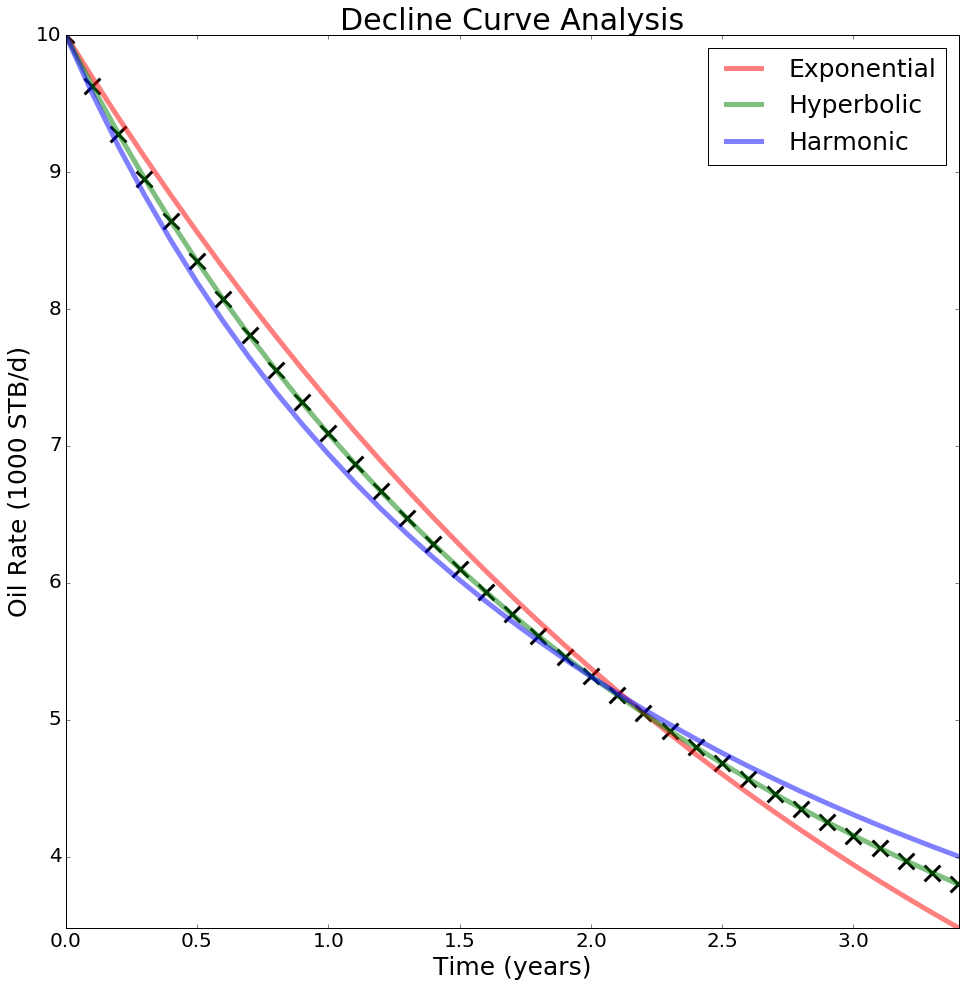

In [6]:
fig, ax = plt.subplots(1, figsize=(16, 16))

ax.set_title("Decline Curve Analysis", fontsize=30)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

ax.scatter(T, Q, color="black", marker="x", s=250, linewidth=3)
ax.set_xlabel("Time (years)", fontsize=25)
ax.set_ylabel("Oil Rate (1000 STB/d)", fontsize=25)

pred_exp = exp_decline(T, popt_exp[0])
pred_hyp = hyp_decline(T, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T, popt_har[0])

min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")
ax.ticklabel_format(fontsize=25)
ax.legend(fontsize=25)

Finally, we will use our decline curves to predict the production for the following 7 years.

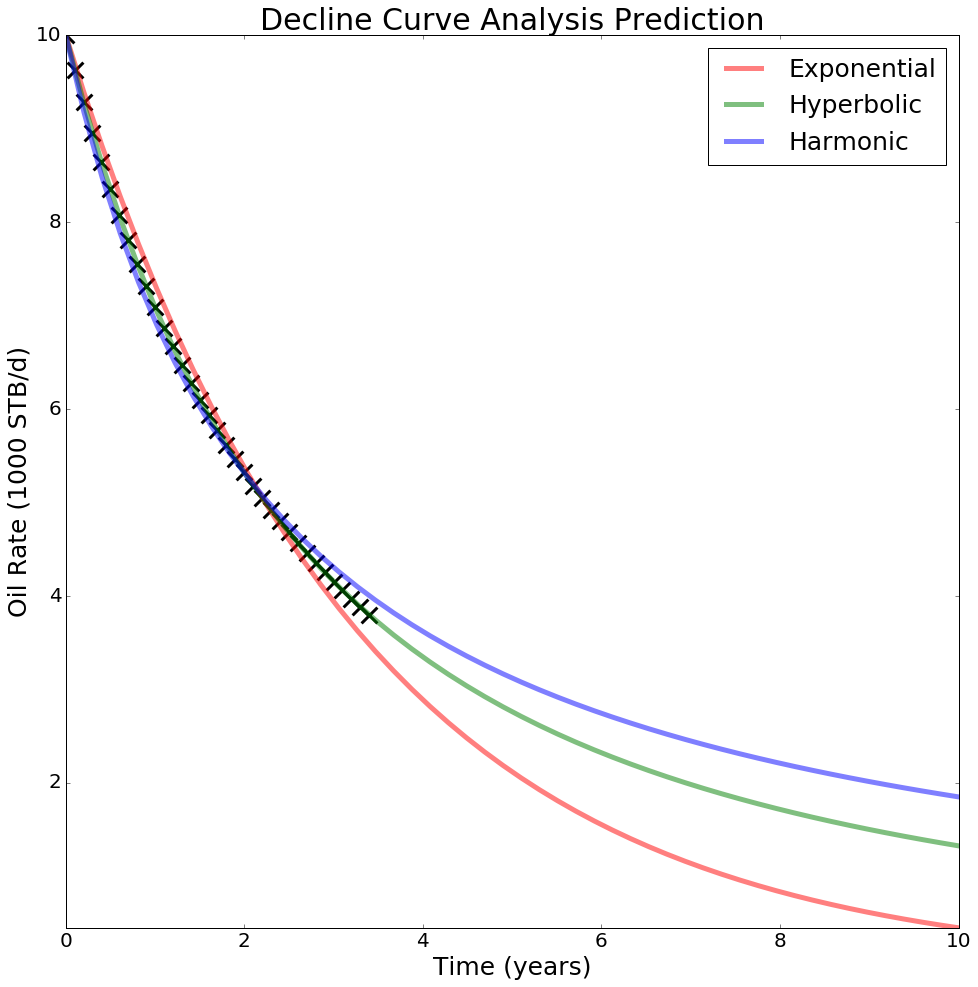

In [7]:
fig, ax = plt.subplots(1, figsize=(16, 16))

T_max = 10.0
T_pred = np.linspace(min(T), T_max)

ax.set_title("Decline Curve Analysis Prediction", fontsize=30)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

ax.scatter(T, Q, color="black", marker="x", s=250, linewidth=3)
ax.set_xlabel("Time (years)", fontsize=25)
ax.set_ylabel("Oil Rate (1000 STB/d)", fontsize=25)

pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])

min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T_pred, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T_pred, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T_pred, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")
ax.ticklabel_format(fontsize=25)
ax.legend(fontsize=25)

## References

Arps, J.J.: “ Analysis of Decline Curves,” Trans. AIME, 160, 228-247, 1945.


Golan, M. and Whitson, C.M.: Well Performance, International Human Resource
Development Corp., 122-125, 1986.


Economides, M.J., Hill, A.D., and Ehlig-Economides, C.: Petroleum Production
Systems, Prentice Hall PTR, Upper Saddle River, 516-519, 1994. 